# *Yellow is the new black*
------

## Abstract
The creation and propagation of false information has existed since the dawn of time.
Behind these misleading elements are often hidden political or financial intentions, in order to gain credit or make competitors lose it.
With the advent of the Internet and the ever faster and more direct flow of information, it is becoming easier every day to deceive your fellow citizens and to be fooled.
The term *fake news* took on a new dimension during the 2016 American presidential election, when Donald Trump used it extensively to describe the media coverage about himself. In this instantaneous era, it becomes crucial to be able to be critical of the information received. With this work, we want to highlight the risks related to the propagation of false information by using the fakes news themselves, from the Liar database. The power that these fake new vehicles hold is mostly in the use and resonance we make of them. Our credulity becomes credibility, it's up to us to turn the equation the other way around!

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import urllib
from urllib.request import Request, urlopen
import json
from bs4 import BeautifulSoup
from PIL import Image

<div class="alert alert-block alert-info"><b>To do: </b>
<br />- Part A: Data Loading and expanding <br />
- Part B: Majority subjects and profession among the liars analysis<br />
- Part C: Geographical analysis<br />
- Part D: Vocabulary analysis<br />
</div>

------

## Data Loading and Cleaning

In [2]:
datapath = 'data/liar_dataset/'

The files are simple *tsv* which is similar to *csv* with tabs instead of comma. All the columns names are known from the `README` files that accompagne the data

In [3]:
columns = ['ID', 
           'Label', 
           'Statement', 
           'Subject', 
           'Speaker', 
           'Job title', 
           'Home State', 
           'Party Affiliations', 
           'Barely True Counts', 
           'False Counts', 
           'Half True Counts', 
           'Mostly True Counts', 
           'Pants on Fire Counts', 
           'Context']
liar_df = pd.read_csv(datapath + 'train.tsv',delimiter='\t',encoding='utf-8', names = columns)

* Column 1: the ID of the statement ([ID].json).
* Column 2: the label.
* Column 3: the statement.
* Column 4: the subject(s).
* Column 5: the speaker.
* Column 6: the speaker's job title.
* Column 7: the state info.
* Column 8: the party affiliation.
* Column 9-13: the total credit history count, including the current statement.
    * 9: barely true counts.
    * 10: false counts.
    * 11: half true counts.
    * 12: mostly true counts.
    * 13: pants on fire counts.
* Column 14: the context (venue / location of the speech or statement).

In [4]:
liar_df.head()

,ID,Label,Statement,Subject,Speaker,Job title,Home State,Party Affiliations,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


------

This function allows to extract additionnal information from the politifact website by downloading the json source file and returning the json structure parsed.

In [5]:
def get_additional_info(ID):
    idx =  re.search("[0-9]*", ID)
    req = Request('http://www.politifact.com//api/v/2/statement/'+idx.group()+'/?format=json', headers={'User-Agent': 'Mozilla/5.0'})
    response = urllib.request.urlopen(req, timeout=10).read().decode('utf-8')
    a = json.loads(response)
    return a

In [6]:
print(BeautifulSoup(get_additional_info("1123.json")['statement'], 'html.parser').prettify())
#get_additional_info("1123.json")['statement_date']

<p>
 Health care reform legislation is “likely to mandate free ‘sex change’ surgeries.”
</p>


In [7]:
liar_df['Date'] = pd.Series(np.zeros(len(liar_df)), index=liar_df.index)

In [8]:
#for i in range(0,len(liar_df)):
#    liar_df.loc[i,'Date'] = get_additional_info(liar_df.loc[i,'ID'])['statement_date']

In [9]:
liar_df['Date'] = pd.to_datetime(liar_df['Date'])

------

All of the result and interpretation we can have from this dataset are conditionned on it. More precisely, the dataset has been constructed from differents sources of media. This selection can be biased. To lower the impact of this bias, the authors have make sure to balance the numbers of article extrated between the two american political parties. But this balance can or cannot represent the reality. It can be interesting to check it the sampling can be considered as representative or not.

------

In [10]:
def get_truth_distribution(data, col_name, count_threshold, normalize = True):
    df = data[[col_name, "ID", "Label"]]
    df.columns = [col_name, "Percent", "Label"]
    col_subject = df.groupby([col_name, "Label"]).count()[["Percent"]]
    col_subject = col_subject.unstack('Label')
    col_subject = col_subject.fillna(0)
    col_subject = col_subject[[('Percent', 'false'), ('Percent', 'pants-fire'), ('Percent', 'barely-true'),('Percent', 'half-true'),('Percent', 'mostly-true'),('Percent', 'true')]]
    col_subject = col_subject[col_subject.sum(axis = 1) >= count_threshold]
    if normalize == True:
        col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
    col_subject = col_subject.sort_values(by=[('Percent', 'false')], ascending = False)
    return col_subject

---
## Determine which are the main subjects falsely propagated in the United States.

In [11]:
liar_df['Label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [12]:
subject_distribution = get_truth_distribution(liar_df, "Subject", 100)
subject_distribution

Percent                                               \
Label                    false pants-fire barely-true half-true mostly-true   
Subject                                                                       
health-care           0.249344   0.097113    0.173228  0.199475    0.133858   
immigration           0.209486   0.098814    0.166008  0.229249    0.209486   
elections             0.206349   0.119048    0.126984  0.142857    0.174603   
economy               0.175182   0.021898    0.175182  0.218978    0.167883   
candidates-biography  0.173684   0.136842    0.205263  0.115789    0.168421   
taxes                 0.172078   0.068182    0.162338  0.220779    0.204545   
federal-budget        0.165289   0.041322    0.115702  0.239669    0.231405   
guns                  0.161538   0.084615    0.115385  0.230769    0.184615   
economy,jobs          0.144000   0.040000    0.112000  0.296000    0.192000   
education             0.143460   0.037975    0.143460  0.219409    0.265823   

                                
Label                     true  
Subject                         
health-care           0.146982  
immigration           0.086957  
elections             0.230159  
economy               0.240876  
candidates-biography  0.200000  
taxes                 0.172078  
federal-budget        0.206612  
guns                  0.223077  
economy,jobs          0.216000  
education             0.189873

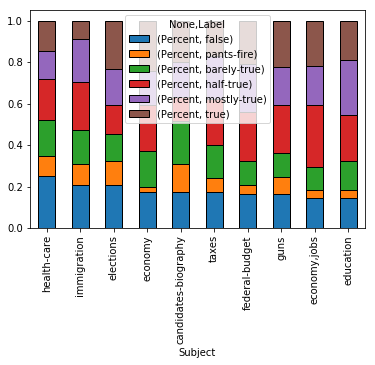

In [13]:
subject_distribution.plot(kind='bar', stacked=True, ec='black')

---
## What are the preferred formats for which topics?

### What are the preferred context to lie?

In [14]:
context_distribution = get_truth_distribution(liar_df, "Context", 100) 
context_distribution

Percent                                               \
Label                 false pants-fire barely-true half-true mostly-true   
Context                                                                    
an interview       0.253275   0.056769    0.131004  0.205240    0.205240   
a radio interview  0.226415   0.084906    0.179245  0.207547    0.132075   
a press release    0.183857   0.058296    0.152466  0.206278    0.201794   
a news release     0.182573   0.091286    0.186722  0.190871    0.170124   
a tweet            0.179487   0.108974    0.147436  0.147436    0.243590   
a speech           0.158879   0.037383    0.112150  0.252336    0.233645   
a TV ad            0.150000   0.072222    0.216667  0.255556    0.200000   
a campaign ad      0.143939   0.053030    0.363636  0.234848    0.121212   
a television ad    0.138211   0.089431    0.243902  0.308943    0.154472   

                             
Label                  true  
Context                      
an interview       0.148472  
a radio interview  0.169811  
a press release    0.197309  
a news release     0.178423  
a tweet            0.173077  
a speech           0.205607  
a TV ad            0.105556  
a campaign ad      0.083333  
a television ad    0.065041

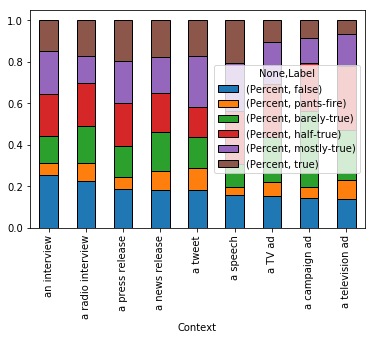

In [15]:
context_distribution.plot(kind='bar', stacked=True, ec='black')

### Are statements in debates more likely to be lies, compared to other speeches?

           Percent                                                   
Label        false pants-fire barely-true half-true mostly-true  true
Context                                                              
a debate.  0.28125    0.15625     0.03125     0.125     0.15625  0.25


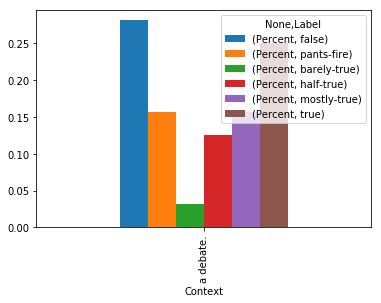

In [16]:
debate = liar_df[liar_df["Context"] == "a debate."]
debate = get_truth_distribution(debate, "Context", 10)
print(debate)
debate.plot(kind='bar')

It seems that the debate are quite polarised in truth distribution. Debater either say completly true or completly false information. The goal in a mediatised debate is not to find the best solution to a problem but to win the debate by getting the more agreement from the audiance. Very polarised idea are then used and false information are intentionaly used because their is no possible immediate fact checking.

### What are the preferred format for witch topic?

In [17]:
df = liar_df[["Context", "ID", "Subject"]]
df.columns = ["Context", "Percent", "Subject"]
col_subject = df.groupby(["Context", "Subject"]).count()[["Percent"]]
col_subject = col_subject.unstack('Subject')
col_subject = col_subject.fillna(0)
#col_subject = col_subject[[('Percent', 'false'), ('Percent', 'pants-fire'), ('Percent', 'barely-true'),('Percent', 'half-true'),('Percent', 'mostly-true'),('Percent', 'true')]]
col_subject = col_subject[col_subject.sum(axis = 1) >= 100]
col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
col_subject = col_subject.loc[:, (col_subject != 0).any(axis=0)]
col_subject.head(3)

Percent                             \
Subject        climate-change,environment health-care state-finances   
Context                                                                
a TV ad                          0.005556    0.033333       0.000000   
a campaign ad                    0.007576    0.015152       0.000000   
a news release                   0.000000    0.024896       0.004149   

                                                                            \
Subject        education      guns     crime   nuclear immigration history   
Context                                                                      
a TV ad         0.027778  0.005556  0.005556  0.005556    0.022222     0.0   
a campaign ad   0.000000  0.000000  0.000000  0.007576    0.000000     0.0   
a news release  0.020747  0.008299  0.004149  0.000000    0.012448     0.0   

                                         ...             \
Subject        foreign-policy            ...              
Context                                  ...              
a TV ad              0.022222            ...              
a campaign ad        0.000000            ...              
a news release       0.000000            ...              

                                                \
Subject        health-care,states,transparency   
Context                                          
a TV ad                                    0.0   
a campaign ad                              0.0   
a news release                             0.0   

                                                              \
Subject        income,jobs,state-budget,state-finances,taxes   
Context                                                        
a TV ad                                                  0.0   
a campaign ad                                            0.0   
a news release                                           0.0   

                                                 \
Subject        job-accomplishments,jobs,workers   
Context                                           
a TV ad                                     0.0   
a campaign ad                               0.0   
a news release                              0.0   

                                                \
Subject        jobs,occupy-wall-street,workers   
Context                                          
a TV ad                                    0.0   
a campaign ad                              0.0   
a news release                             0.0   

                                                           \
Subject        jobs,state-finances,tourism,transportation   
Context                                                     
a TV ad                                               0.0   
a campaign ad                                         0.0   
a news release                                        0.0   

                                                               \
Subject        labor,legal-issues,state-budget,unions,workers   
Context                                                         
a TV ad                                                   0.0   
a campaign ad                                             0.0   
a news release                                            0.0   

                                                                        \
Subject        labor,public-safety legal-issues,marijuana,polls,states   
Context                                                                  
a TV ad                        0.0                                 0.0   
a campaign ad                  0.0                                 0.0   
a news release                 0.0                                 0.0   

                                                                
Subject        state-budget,stimulus state-budget,transparency  
Context                                                         
a TV ad                          0.0                       0.0  
a campaign ad       

Well ... I don't really know what to say on that

### Compare distribution of fake news between traditional press, speeches and social media

In [18]:
context_distribution = get_truth_distribution(liar_df, "Context", 10, normalize = False) 
context_distribution.head()

Percent                                                   
Label             false pants-fire barely-true half-true mostly-true  true
Context                                                                   
an interview       58.0       13.0        30.0      47.0        47.0  34.0
a news release     44.0       22.0        45.0      46.0        41.0  43.0
a press release    41.0       13.0        34.0      46.0        45.0  44.0
a speech           34.0        8.0        24.0      54.0        50.0  44.0
a tweet            28.0       17.0        23.0      23.0        38.0  27.0

* Traditional press

In [19]:
traditional_press_regex = re.compile(r'\b(ABC|TV|CNN|MSNBC|radio|interview|newspaper|press)[s]*\b' ,re.I)
traditional_press_sets = context_distribution[context_distribution.index.str.contains(traditional_press_regex, regex=True) == True]
traditional_press_sets.head()

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


Percent                                               \
Label                    false pants-fire barely-true half-true mostly-true   
Context                                                                       
an interview              58.0       13.0        30.0      47.0        47.0   
a press release           41.0       13.0        34.0      46.0        45.0   
a TV ad                   27.0       13.0        39.0      46.0        36.0   
a radio interview         24.0        9.0        19.0      22.0        14.0   
a television interview    15.0        2.0        10.0      15.0        12.0   

                              
Label                   true  
Context                       
an interview            34.0  
a press release         44.0  
a TV ad                 19.0  
a radio interview       18.0  
a television interview  14.0

In [41]:
traditional_press_sets.sum()

         Label      
Percent  false          344.0
         pants-fire      97.0
         barely-true    278.0
         half-true      366.0
         mostly-true    334.0
         true           281.0
dtype: float64

* Social media

In [20]:
social_media_regex = re.compile(r'\b(Facebook|blog|twitter|my space|newsletter|video|email|tweet|social media|YouTube)[s]*\b' ,re.I)
social_media_sets = context_distribution[context_distribution.index.str.contains(social_media_regex, regex=True) == True]
social_media_sets.head()

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


Percent                                                   
Label             false pants-fire barely-true half-true mostly-true  true
Context                                                                   
a tweet            28.0       17.0        23.0      23.0        38.0  27.0
a Facebook post    13.0       13.0        17.0      14.0        11.0   6.0
a chain email       9.0       16.0         1.0       0.0         0.0   0.0
a blog post         8.0        6.0         4.0       3.0         3.0   4.0
an email            7.0        5.0         3.0       5.0         2.0   2.0

In [50]:
social_media_sum =social_media_sets.sum()
social_media_sum

         Label      
Percent  false          111.0
         pants-fire      74.0
         barely-true     87.0
         half-true       94.0
         mostly-true     88.0
         true            71.0
dtype: float64

* Speech

In [22]:
speech_regex = re.compile(r'\b(speech)[s]*\b' ,re.I)
speech_sets = context_distribution[context_distribution.index.str.contains(speech_regex, regex=True) == True]
speech_sets.head()

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


Percent                                   \
Label                         false pants-fire barely-true half-true   
Context                                                                
a speech                       34.0        8.0        24.0      54.0   
a speech.                      16.0        4.0        13.0       5.0   
a speech on the House floor     7.0        1.0         0.0       7.0   
a campaign speech               6.0        1.0         3.0       7.0   
a Senate floor speech           6.0        2.0         2.0       1.0   

                                               
Label                       mostly-true  true  
Context                                        
a speech                           50.0  44.0  
a speech.                           7.0  12.0  
a speech on the House floor         5.0   1.0  
a campaign speech                   6.0   2.0  
a Senate floor speech               4.0   4.0

In [42]:
speech_sets.sum()

         Label      
Percent  false          80.0
         pants-fire     18.0
         barely-true    54.0
         half-true      90.0
         mostly-true    91.0
         true           78.0
dtype: float64

---
## What are the most prominent professions among the liars?

### Professions truth distribution ?

In [23]:
profession_distribution = get_truth_distribution(liar_df, "Job title", 30) 
profession_distribution.head()

Percent                         \
Label                                       false pants-fire barely-true   
Job title                                                                  
President-Elect                          0.369963   0.190476    0.175824   
Congresswoman                            0.360000   0.220000    0.160000   
Attorney General                         0.303030   0.030303    0.060606   
Congressman                              0.300000   0.025000    0.125000   
Speaker of the House of Representatives  0.280000   0.040000    0.180000   

                                                                         
Label                                   half-true mostly-true      true  
Job title                                                                
President-Elect                          0.142857    0.098901  0.021978  
Congresswoman                            0.120000    0.060000  0.080000  
Attorney General                         0.272727    0.212121  0.121212  
Congressman                              0.212500    0.175000  0.162500  
Speaker of the House of Representatives  0.160000    0.080000  0.260000

### What are the most prominent professions in the dataset ?

In [24]:
jobs = liar_df.groupby("Job title").count()
jobs = jobs.sort_values(by=['ID'], ascending = False)
jobs = jobs[["ID"]]
jobs.head()

,ID
Job title,
President,492
U.S. Senator,479
Governor,391
President-Elect,273
U.S. senator,263


### Among the liars ??

For each Statement, we can access the job title of the speaker. That way, we can access the most frequent jobs in the liar groups for this specific dataset.

In [25]:
lie = liar_df[liar_df['Label'] == 'false']
jobs_lie = lie.groupby("Job title").count()
jobs_lie = jobs_lie[["ID"]]
jobs_lie.shape

(403, 1)

In [26]:
jobs_lie = jobs_lie.sort_values(by=['ID'], ascending = False)
jobs_lie.head()

,ID
Job title,
President-Elect,101
Governor,75
President,68
U.S. Senator,66
U.S. senator,51


Because all the jobs don't have the same media coverage, it is more interesting to have the percentage of lie of the job than the raw numbers themselves

In [27]:
jobs_lie = jobs_lie.join(jobs, lsuffix = '_lie', rsuffix = '_total')

In [28]:
jobs_lie["ratio (%)"] =jobs_lie["ID_lie"]/jobs_lie["ID_total"]*100

In [29]:
jobs_lie = jobs_lie.sort_values(by=['ID_total'], ascending = False)

### Lie in politics

The people that have a political message generaly have a party affiliation.

In [30]:
lie_party = lie[lie['Party Affiliations'] != 'none']
lie_party = lie_party.groupby("Job title").count()
lie_party = lie_party[["ID"]].sort_values(by=['ID'], ascending = False)
lie_party.head()

,ID
Job title,
President-Elect,101
Governor,75
President,68
U.S. Senator,66
U.S. senator,51


In [31]:
politics_regex = re.compile(r'\b(mayor|president|council|house|candidate|political|assembly|republican|governor|senator)[s]*\b' ,re.I)
politics_liar_sets = jobs_lie[jobs_lie.index.str.contains(politics_regex, regex=True) == True]
politics_liar_sets.head()

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


,ID_lie,ID_total,ratio (%)
Job title,,,
President,68,492,13.821138
U.S. Senator,66,479,13.778706
Governor,75,391,19.181586
President-Elect,101,273,36.996337
U.S. senator,51,263,19.391635


---
## Highlight which political parties tend to lie the most.

In [32]:
col = "Party Affiliations"
df = liar_df[[col, "ID", "Label"]]
df.columns = [col, "Count", "Label"]
col_subject = df.groupby([col, "Label"]).count()[["Count"]]
col_subject = col_subject.unstack('Label')
col_subject = col_subject.fillna(0)
col_subject = col_subject.sort_values(by=[('Count', 'false')], ascending = False)
col_subject = col_subject[[('Count', 'false'), ('Count', 'pants-fire'), ('Count', 'barely-true'),('Count', 'half-true'),('Count', 'mostly-true'),('Count', 'true')]]
col_subject

Count                                   \
Label                          false pants-fire barely-true half-true   
Party Affiliations                                                      
republican                    1028.0      380.0       832.0     890.0   
democrat                       511.0      153.0       463.0     750.0   
none                           326.0      269.0       261.0     327.0   
organization                    50.0       17.0        45.0      59.0   
independent                     18.0        3.0        19.0      27.0   
journalist                      10.0        1.0         5.0       6.0   
columnist                       10.0        1.0         5.0       3.0   
talk-show-host                   9.0        4.0         2.0       6.0   
newsmaker                        9.0        3.0         7.0      11.0   
activist                         7.0        0.0         7.0       9.0   
libertarian                      6.0        3.0         4.0      12.0   
labor-leader                     2.0        1.0         2.0       1.0   
tea-party-member                 2.0        1.0         0.0       4.0   
green                            1.0        1.0         0.0       0.0   
constitution-party               1.0        0.0         0.0       0.0   
state-official                   1.0        0.0         1.0       8.0   
business-leader                  1.0        2.0         0.0       0.0   
Moderate                         1.0        0.0         0.0       0.0   
liberal-party-canada             0.0        0.0         0.0       0.0   
government-body                  0.0        0.0         0.0       0.0   
education-official               0.0        0.0         0.0       0.0   
ocean-state-tea-party-action     0.0        0.0         1.0       0.0   
democratic-farmer-labor          0.0        0.0         0.0       1.0   

                                                 
Label                        mostly-true   true  
Party Affiliations                               
republican                         707.0  660.0  
democrat                           801.0  658.0  
none                               315.0  246.0  
organization                        24.0   24.0  
independent                         51.0   29.0  
journalist                          11.0    5.0  
columnist                            5.0   11.0  
talk-show-host                       0.0    5.0  
newsmaker                           11.0   15.0  
activist                            11.0    5.0  
libertarian                          9.0    6.0  
labor-leader                         3.0    2.0  
tea-party-member                     3.0    0.0  
green                                0.0    1.0  
constitution-party                   0.0    0.0  
state-official                       6.0    4.0  
business-leader                      1.0    5.0  
Moderate                             0.0    0.0  
liberal-party-canada                 1.0    0.0  
government-body                      1.0    0.0  
education-official                   2.0    0.0  
ocean-state-tea-party-action         0.0    0.0  
democratic-farmer-labor              0.0    0.0

In [33]:
col_subject = col_subject.head(2)
normalized_col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
normalized_col_subject =normalized_col_subject.transpose()

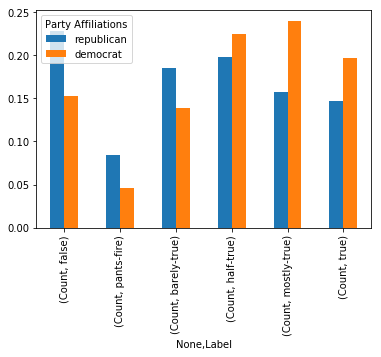

In [34]:
normalized_col_subject.plot(kind='bar')

---
## Test data visualisation

In [35]:
from wordcloud import WordCloud

# Read the whole text.
text = open('res/test_plain_text.txt').read()

In [36]:
text = BeautifulSoup(get_additional_info("1123.json")['statement'], 'html.parser').prettify()

In [37]:
text

'<p>\n Health care reform legislation is “likely to mandate free ‘sex change’ surgeries.”\n</p>'

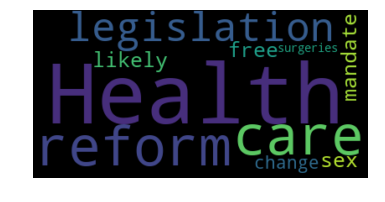

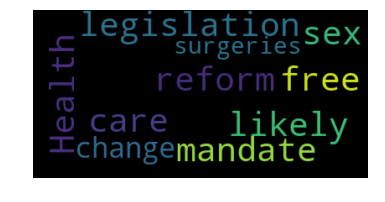

In [38]:
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

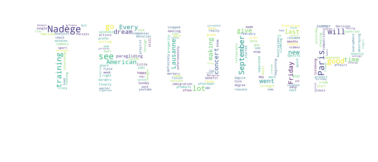

<Figure size 432x288 with 0 Axes>

In [39]:
text = open('res/test_plain_text.txt').read()
#text = BeautifulSoup(get_additional_info("1123.json")['statement'], 'html.parser').prettify()
# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
trump_mask = np.array(Image.open('res/Trumpy3.png'))
wc = WordCloud(background_color="white", max_words=2000, mask=trump_mask,contour_width=0, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

In [40]:
#https://matplotlib.org/gallery/images_contours_and_fields/image_clip_path.html#sphx-glr-gallery-images-contours-and-fields-image-clip-path-py
#https://www.politifact.com//api/v/2/statement/1123/?format=json